In [1]:
import numpy as np
import h5py
#compute filter importance scores
f = h5py.File("scores.h5","r")
hyp_scores = np.array(f['hyp_imp'][:])
sequence_onehot = np.array(f['seq'][:])
imp_scores = sequence_onehot*hyp_scores

In [2]:
TAL1_hocomoco_pwm = np.array([
[float(x) for x in row.split("\t")] for row in
"""-0.1534218054606978	0.4248884005542006	0.03874842366748681	-0.5563400288274302
0.6464252650829619	-0.19096598877289345	-0.4517428977281205	-0.46423468265484735
0.09778278471982192	-1.7701210752371432	0.6587683755978941	-0.22997490888551778
-0.3570577390357126	0.015679997751073114	0.6949091007770549	-1.2696234647115647
0.7960986345594286	-0.1534218054606978	-0.9376103830414496	-0.6277442179623938
0.8847264425178556	-2.2340103118057417	-0.14425194284148976	-0.5026745162600582
0.46041545716766114	-0.7879487534832245	0.6505565864406581	-3.1262106111200567
-1.9199997006100191	1.3217083373824634	-2.694308015795771	-3.324736791140142
1.3068477609048863	-3.903141843818025	-3.324736791140142	-1.3889770090864402
-2.8186351867496584	-1.2418852451298863	1.229040024674195	-1.454459020739145
0.4453438583421999	0.3272783608001891	-0.14425194284148976	-1.6813854611337156
-1.2418852451298863	-2.9606438896517475	-2.2340103118057417	1.2675888612037503
-1.8176277056823105	-2.694308015795771	1.2496331898723319	-1.2696234647115647
-1.000060890477635	-0.6887818819947552	0.3215658109169486	0.5599984365563851
-0.7537887239776389	-0.03211743511552166	0.274651146968163	0.21909970310567795""".split("\n")])

TF-MoDISco is using the TensorFlow backend.


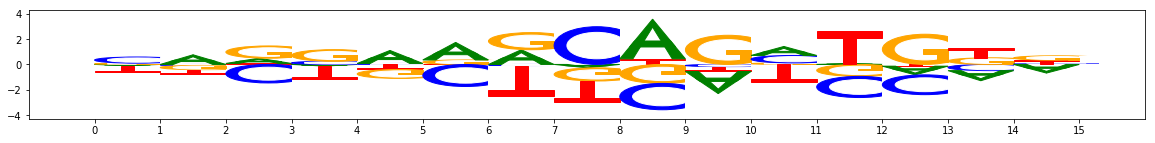

In [3]:
%matplotlib inline
from modisco.visualization import viz_sequence
viz_sequence.plot_weights(TAL1_hocomoco_pwm-np.mean(TAL1_hocomoco_pwm,axis=-1)[:,None])

In [4]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def scan_deeplift_scores_with_pwm(imp_scores, pwm):
    strided_arr = rolling_window(imp_scores.transpose((0,2,1)),
                                 window=len(pwm)).transpose((0,2,3,1))
    #report both the sum and the cosine similarity
    #this finds the sum
    sum_scores = np.sum(strided_arr, axis=(2,3))
    #this finds the cosine similarity with a masked version of the pwm
    # where only the positions that are nonzero in the deeplift scores are
    # considered
    dot_product_pwm = np.sum(strided_arr*pwm[None,None,:,:], axis=(2,3))
    norm_deeplift_scores = np.sqrt(np.sum(np.square(strided_arr), axis=(2,3)))
    norm_masked_pwm = np.sqrt(np.sum(np.square((np.abs(strided_arr)>0)*pwm[None,None,:,:]), axis=(2,3)))
    cosine_sim = dot_product_pwm/(norm_deeplift_scores*norm_masked_pwm)
    return sum_scores, cosine_sim

def pwm_scan(array, pwm):
    strided_arr = rolling_window(array.transpose((0,2,1)), window=len(pwm)).transpose((0,2,3,1))
    pwm_scores = np.sum(strided_arr*pwm[None,None,:,:],axis=(2,3))
    return pwm_scores

tal_pwm_scores = pwm_scan(array=sequence_onehot, pwm=TAL1_hocomoco_pwm)
importance_in_windows, motif_cosine_sim = scan_deeplift_scores_with_pwm(
    imp_scores=imp_scores,
    pwm=TAL1_hocomoco_pwm)

/users/avanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [16]:
from collections import OrderedDict
important_windows = OrderedDict()
sorted_tal_hits = OrderedDict()
for thresh in [0.5]:
    important_windows[thresh] = np.nonzero(importance_in_windows > thresh)
    #sort primarily by TAL hit score, secondarily by importance
    sorted_tal_hits[thresh] = sorted(sorted(zip(importance_in_windows[
                                          important_windows[thresh][0], important_windows[thresh][1]], 
                                         motif_cosine_sim[important_windows[thresh][0], important_windows[thresh][1]],
                                         important_windows[thresh][0],
                                         important_windows[thresh][1]),
                                        key=lambda x: -x[0]),
                                         key=lambda x: -x[1])

In [6]:
import modisco
#load the tfmodisco results object
modisco_file = "unoptimized_results.hdf5"
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=["task0"],
                contrib_scores={"task0": imp_scores},
                hypothetical_contribs={"task0": hyp_scores},
                one_hot=sequence_onehot)
grp = h5py.File(modisco_file,"r")
tfmodisco_results =\
    modisco.tfmodisco_workflow.workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

In [7]:
from collections import defaultdict
coords = (tfmodisco_results.multitask_seqlet_creation_results
            .task_name_to_coord_producer_results["task0"]
            .coords)
example_idx_to_coords = defaultdict(list)
for coord in coords:
    example_idx_to_coords[coord.example_idx].append(
        (coord.start, coord.end))

In [8]:
from importlib import reload
import modisco.coordproducers
reload(modisco.coordproducers)

#this can be used to call coordinates on the fly if needed
coordproducer = modisco.coordproducers.FixedWindowAroundChunks(sliding=21,
                                                               flank=10,
                                                               suppress=20,
                                                               target_fdr=0.2,
                                                               min_passing_windows_frac=0.03,
                                                               max_passing_windows_frac=0.2,
                                                               separate_pos_neg_thresholds=False,
                                                               max_seqlets_total=None,
                                                               verbose=True)

tnt_results = (tfmodisco_results.multitask_seqlet_creation_results
               .task_name_to_coord_producer_results["task0"]
               .tnt_results)

Plotting top TAL hits where total importance at the motif exceeds 0.5
201685 167 0.9660870028255253
coords [(166, 207), (234, 275)]


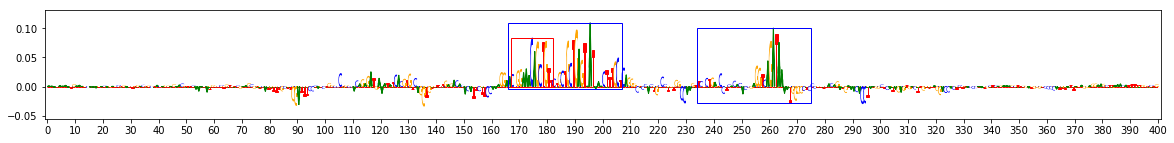

179316 201 0.9613999499800387
coords [(201, 242), (180, 221), (103, 144), (245, 286)]


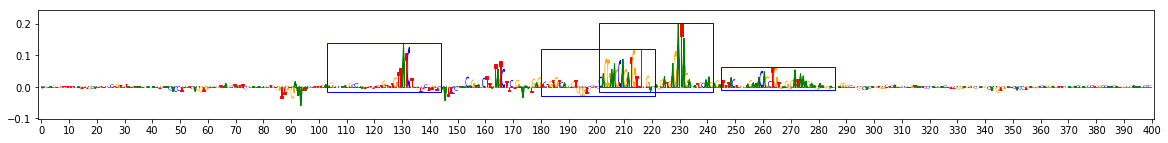

148124 191 0.9560485745413388
coords [(189, 230), (168, 209)]


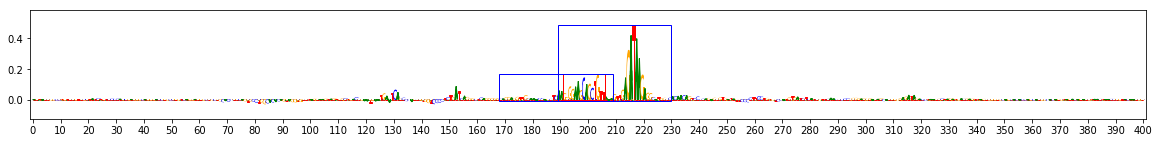

205627 136 0.9478630051399908
coords [(119, 160), (258, 299)]


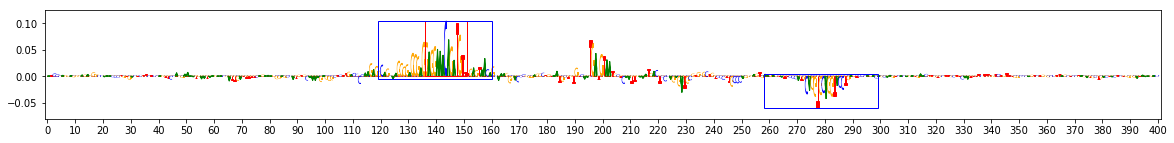

102363 201 0.9462329588721199
coords [(197, 238), (251, 292), (176, 217), (278, 319)]


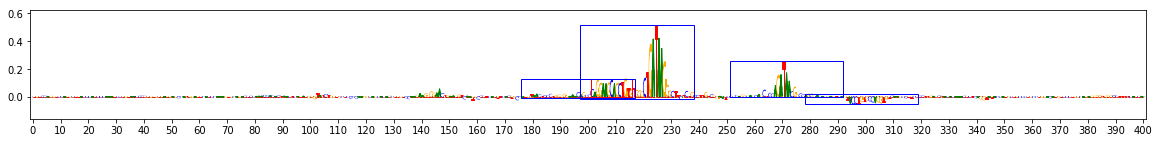

7039 232 0.943432056238754
coords [(226, 267), (205, 246), (144, 185)]


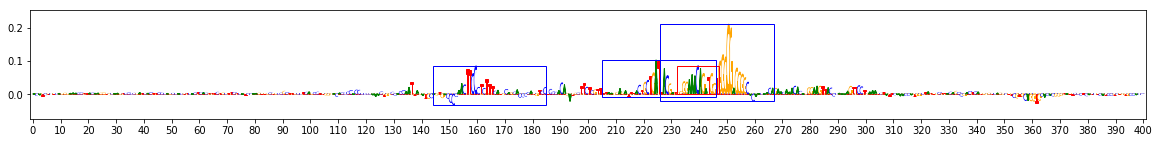

22384 242 0.9414001056343972
coords [(231, 272)]


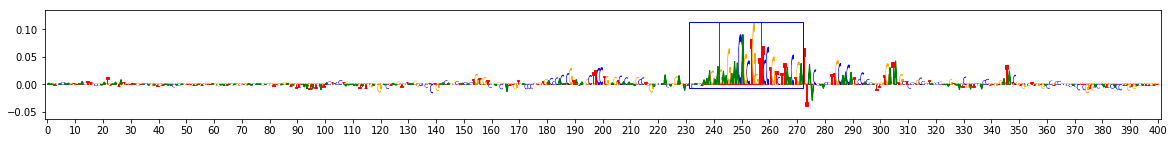

148109 253 0.9396325065659162
coords [(230, 271), (251, 292)]


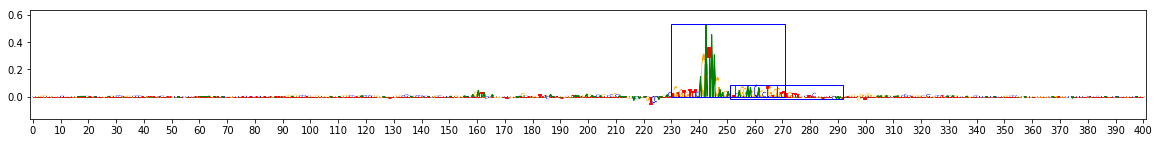

118259 201 0.9395124162673179
coords [(212, 253), (184, 225), (163, 204)]


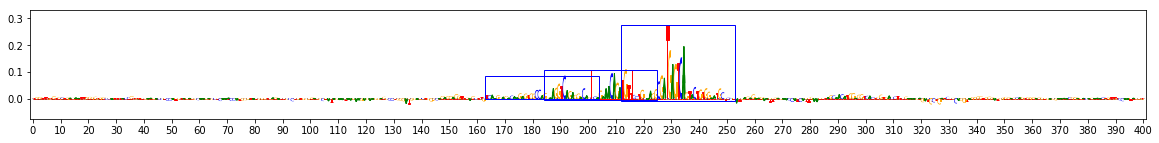

101962 208 0.9387504593625933
coords [(173, 214), (194, 235), (119, 160)]


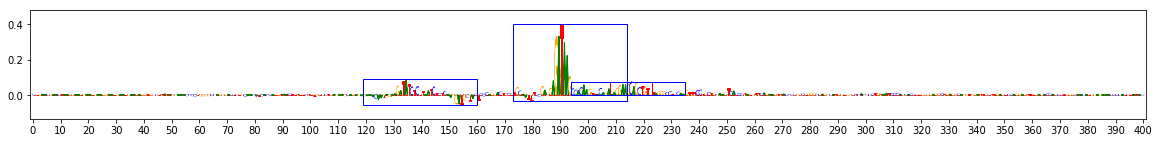

201667 195 0.9387424936835783
coords [(238, 279), (215, 256), (186, 227)]


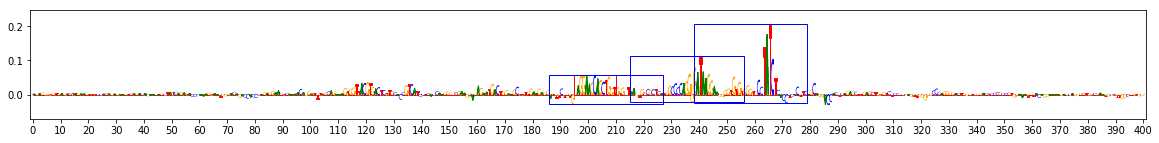

158469 175 0.9358557452850955
coords [(225, 266), (160, 201)]


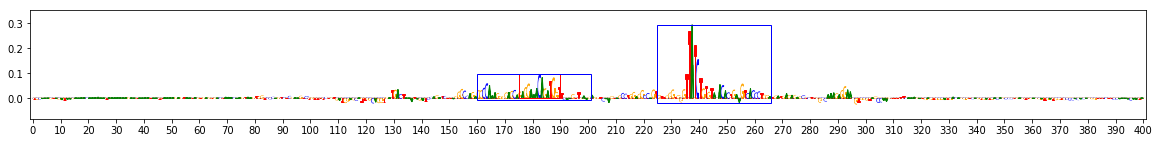

104073 202 0.9355583024467128
coords [(198, 239), (161, 202)]


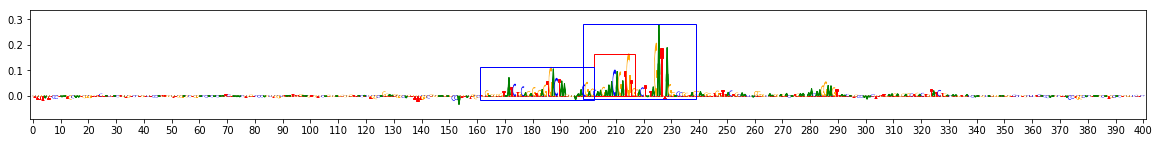

192451 207 0.9347226472680902
coords [(166, 207), (196, 237), (115, 156)]


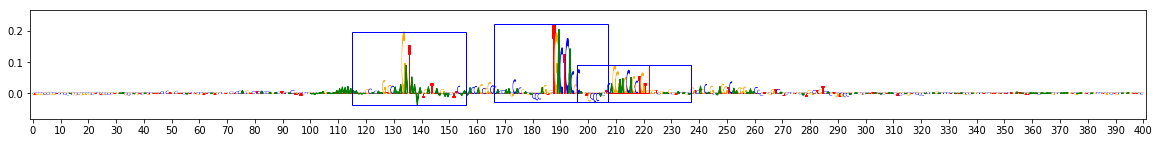

142250 137 0.9342973734446464
coords [(134, 175), (173, 214)]


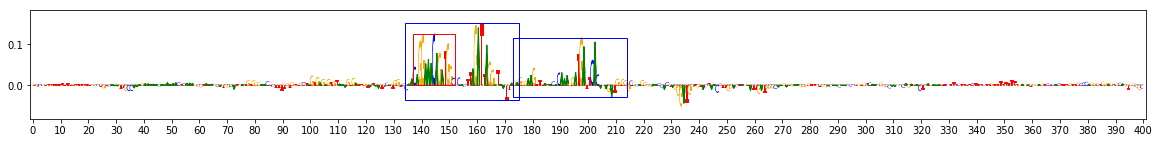

141656 239 0.9285422115733935
coords [(216, 257)]


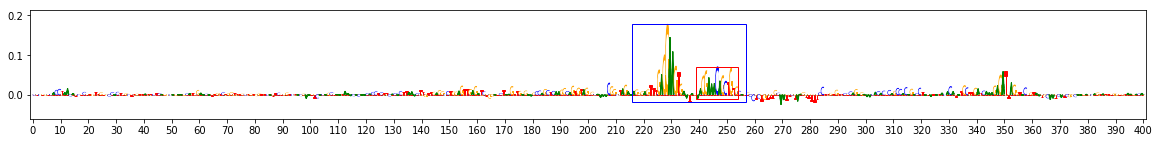

186599 211 0.9284954341396982
coords [(124, 165), (145, 186), (194, 235), (166, 207)]


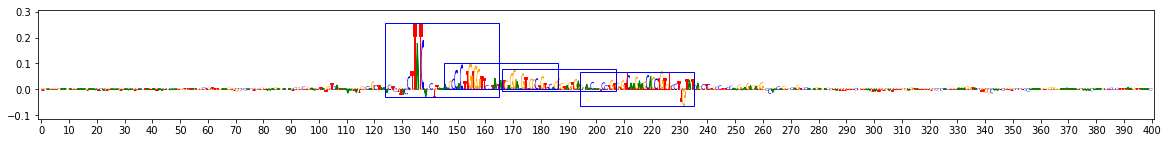

203637 176 0.9219437400854619
coords [(173, 214), (103, 144), (207, 248)]


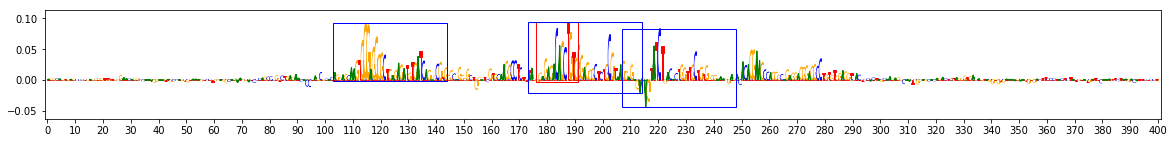

123374 198 0.9213515366238724
coords [(250, 291), (171, 212), (193, 234), (273, 314)]


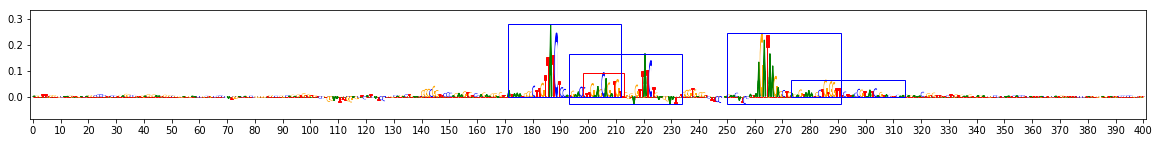

14828 157 0.9213308864270914
coords [(140, 181), (190, 231)]


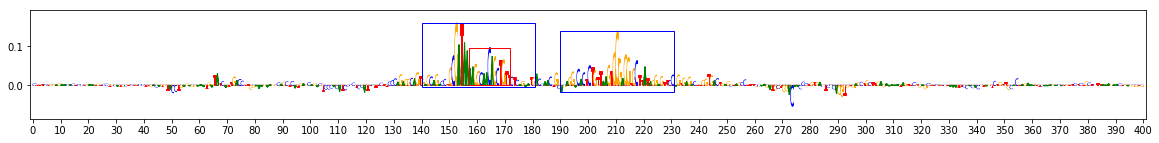

177426 242 0.9194437754429079
coords [(224, 265)]


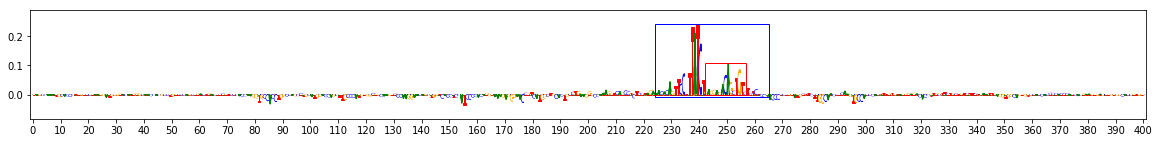

169647 125 0.9179774522981555
coords [(107, 148)]


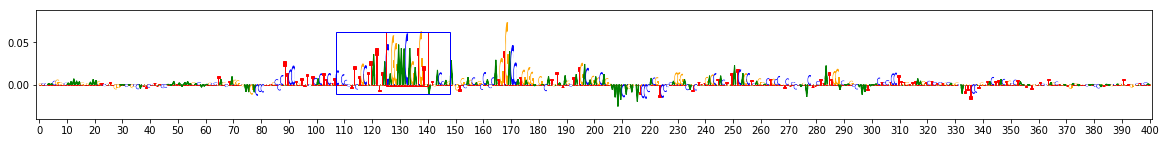

104266 198 0.9165247853711588
coords [(180, 221), (227, 268), (131, 172)]


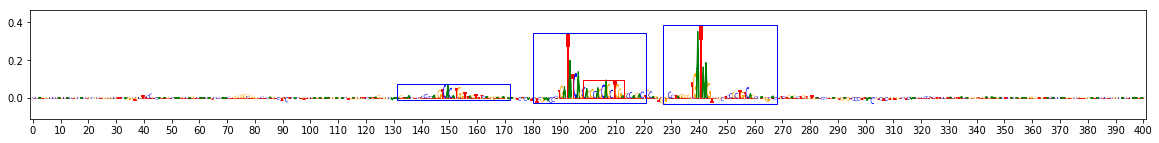

129209 205 0.9157545380973605
coords [(189, 230)]


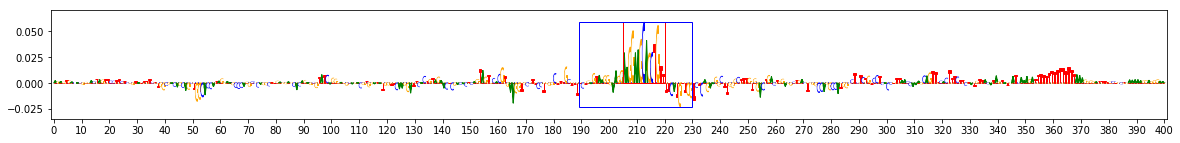

73997 178 0.9153680121301176
coords [(220, 261), (160, 201)]


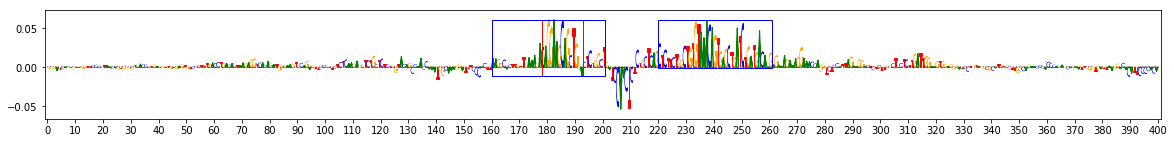

201877 293 0.9140433976008271
coords [(275, 316)]


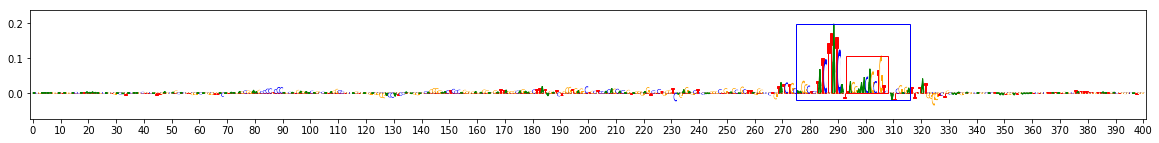

115011 104 0.9122919758704283
coords [(93, 134), (117, 158), (244, 285)]


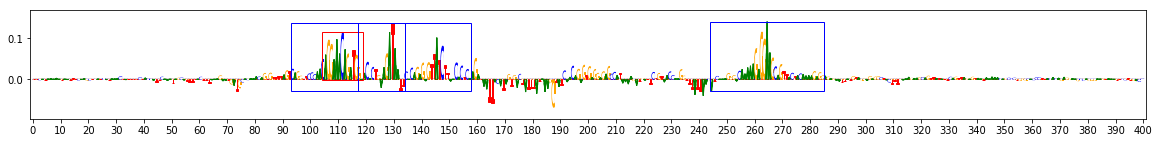

4342 128 0.9110608832917378
coords [(121, 162), (215, 256), (190, 231)]


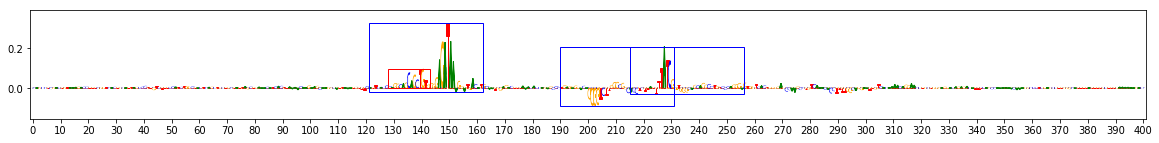

129262 129 0.910299127195141
coords [(120, 161)]


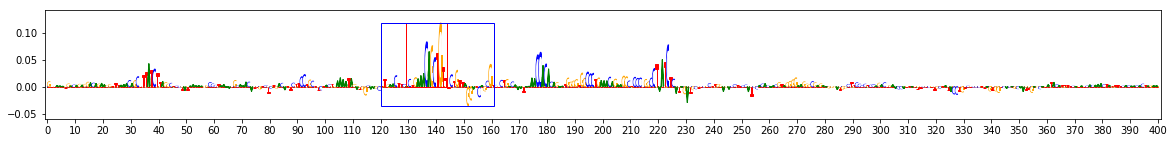

138659 177 0.9099338230526668
coords [(210, 251), (174, 215), (231, 272), (261, 302)]


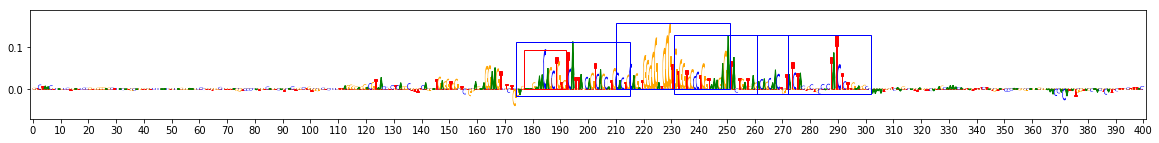

8600 206 0.9099010003955037
coords [(201, 242)]


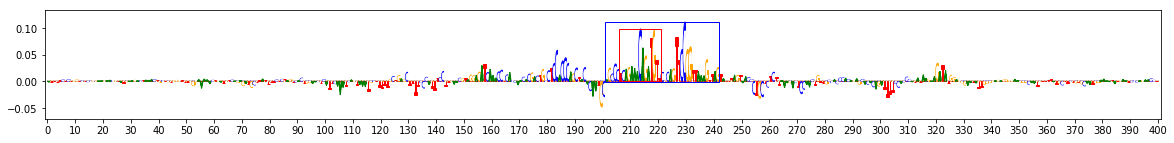

64049 169 0.9077948570301
coords [(151, 192), (192, 233)]


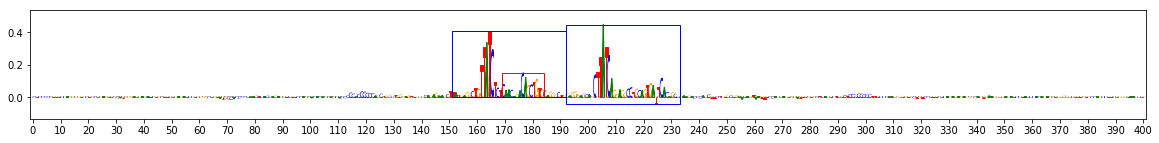

48384 211 0.9076261806251188
coords [(220, 261), (193, 234), (276, 317)]


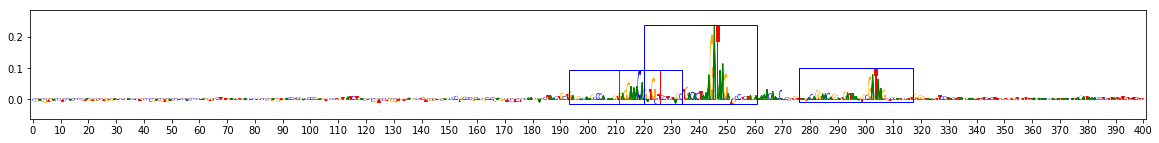

112144 201 0.9071252744803178
coords [(201, 242)]


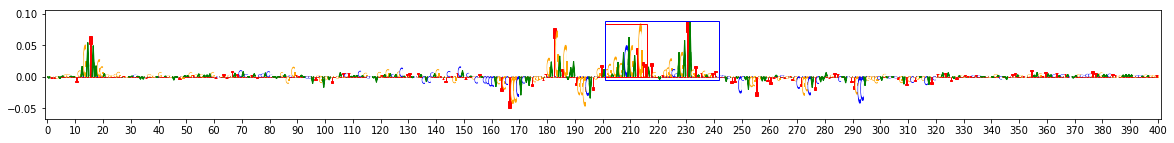

35200 168 0.9062211185541849
coords [(179, 220), (245, 286), (157, 198)]


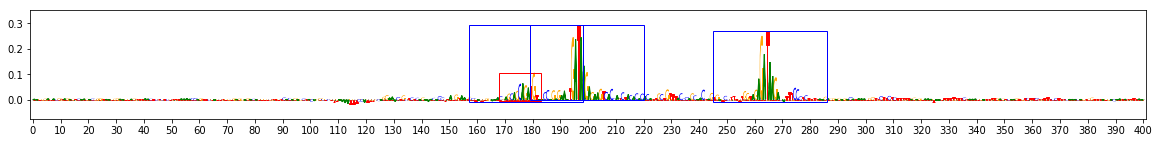

13342 270 0.9060889291903205
coords [(244, 285), (167, 208), (140, 181)]


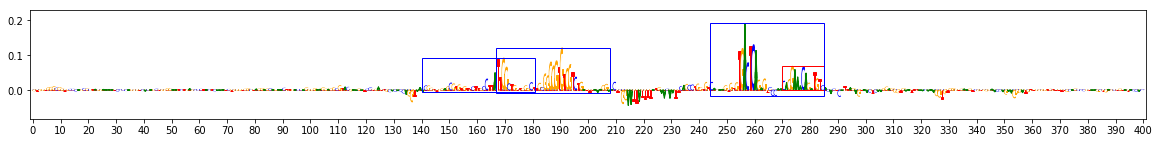

33221 159 0.9060825354038996
coords [(154, 195), (197, 238)]


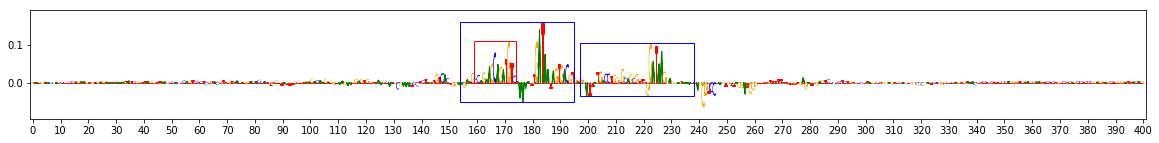

153975 247 0.9052626091218337
coords [(194, 235), (231, 272), (148, 189)]


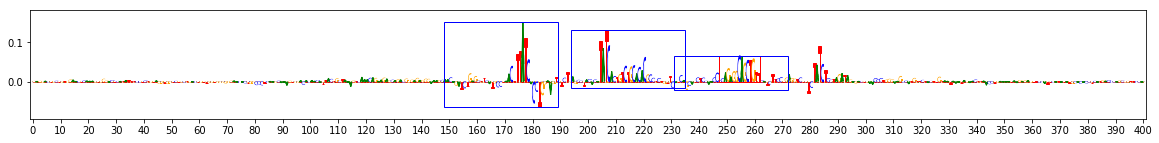

47754 189 0.9050258897692461
coords [(184, 225)]


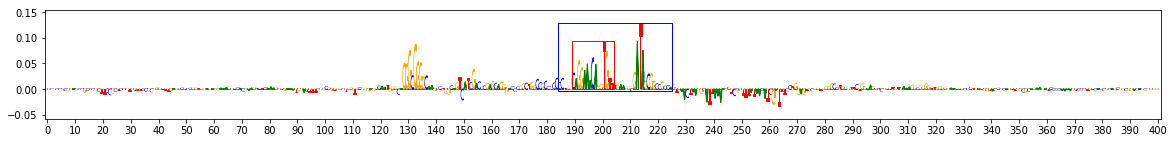

55139 226 0.9039962790350825
coords [(224, 265), (186, 227)]


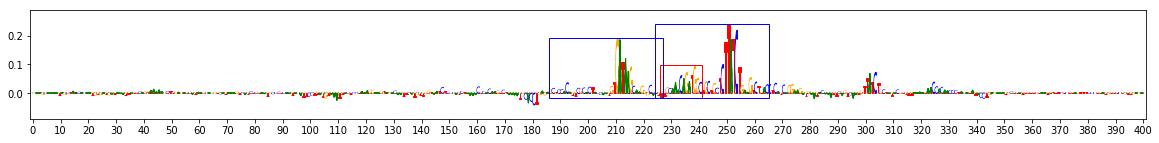

135021 154 0.9038263299340515
coords [(221, 262), (147, 188)]


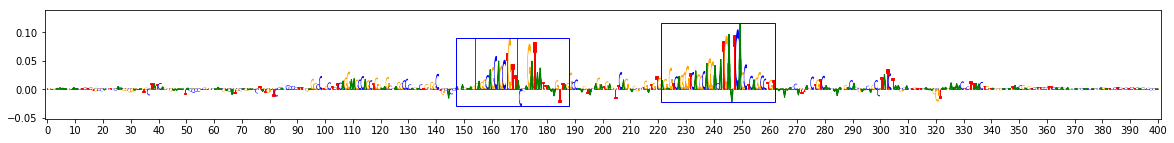

180199 211 0.9036924284994127
coords [(189, 230), (165, 206), (128, 169), (210, 251)]


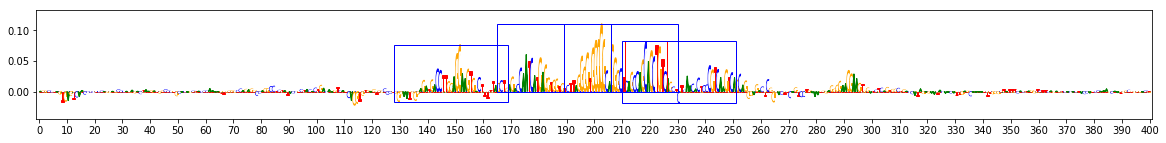

80436 230 0.9027159052281161
coords [(209, 250), (230, 271)]


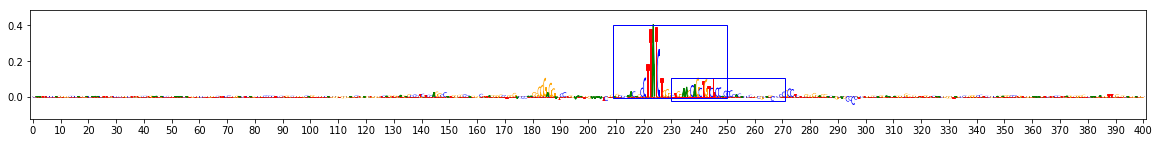

17473 143 0.9021877952831858
coords [(254, 295), (125, 166), (96, 137)]


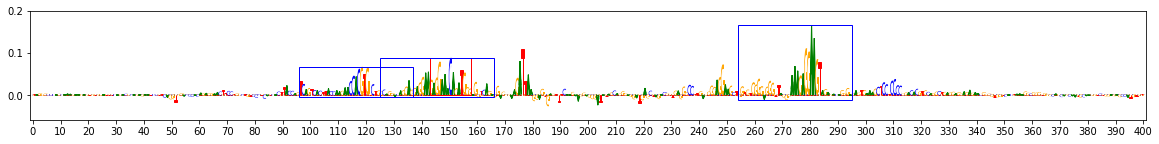

5978 149 0.8998721340871231
coords [(161, 202), (190, 231), (140, 181)]


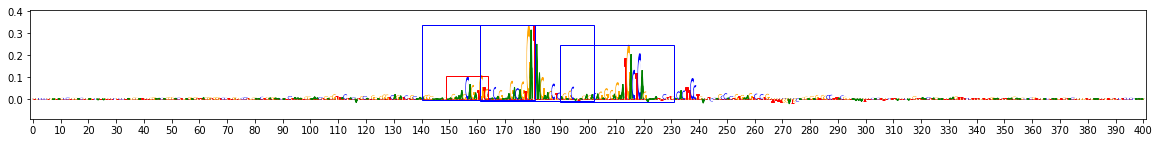

189688 119 0.8986253124646899
coords [(236, 277), (200, 241), (142, 183), (107, 148)]


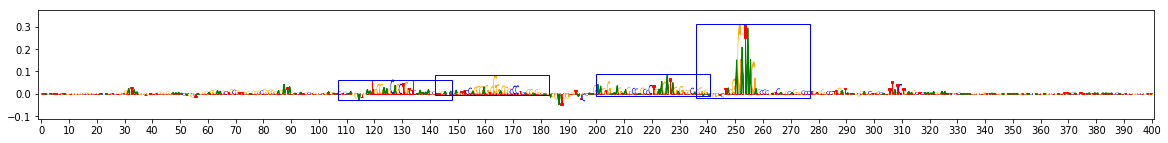

182304 217 0.8983576774192261
coords [(212, 253), (179, 220)]


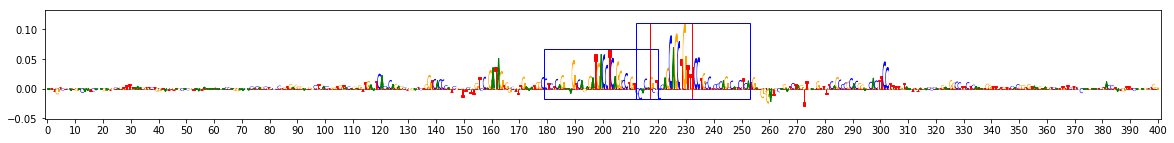

134626 179 0.8981688662995558
coords [(138, 179), (181, 222), (160, 201), (206, 247), (244, 285)]


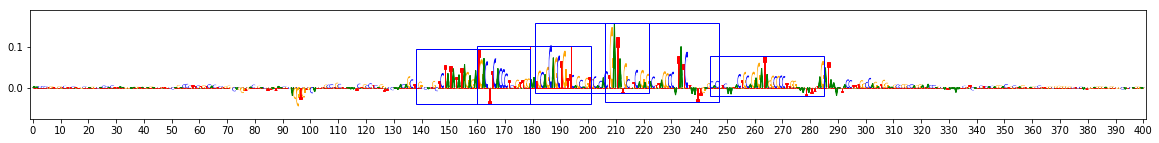

10082 206 0.8976195110282479
coords [(161, 202), (192, 233)]


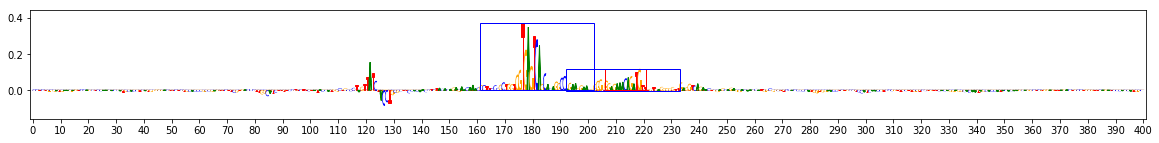

138713 183 0.8959339782126221
coords [(180, 221), (248, 289)]


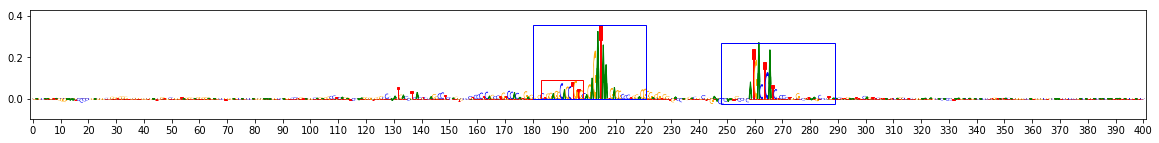

In [17]:
flank=50
for thresh in [0.5]:
    print("Plotting top TAL hits where total importance at the motif exceeds",thresh)
    for idx in range(50):
        example_idx = sorted_tal_hits[thresh][idx][2]
        motif_start = sorted_tal_hits[thresh][idx][3]
        print(example_idx, motif_start, sorted_tal_hits[thresh][idx][1])
        ex_coords = example_idx_to_coords[example_idx]
        #for calling coordinates on the fly if needed
        #ex_coords_2 = [(x.start, x.end) for x in coordproducer(score_track=[np.sum(imp_scores[example_idx], axis=-1)],
        #                               null_track=modisco.coordproducers.LaplaceNullDist(num_to_samp=10000),
        #                               tnt_results=tnt_results).coords]
        print("coords",ex_coords)
        #print("coords2",ex_coords_2)
        viz_sequence.plot_weights(imp_scores[example_idx],
                                             #motif_start-flank:
                                             #motif_start+(flank+len(TAL1_hocomoco_pwm))],
                                  subticks_frequency=10,
                                  highlight={'red':[(motif_start,motif_start+len(TAL1_hocomoco_pwm))],
                                             'blue': ex_coords,
                                             #'green': ex_coords_2
                                            })
        #viz_sequence.plot_weights(sequence_onehot[sorted_tal_hits[thresh][idx][2],
        #                                     sorted_tal_hits[thresh][idx][3]-flank:
        #                                     sorted_tal_hits[thresh][idx][3]+(flank+len(TAL1_hocomoco_pwm))],
        #                          subticks_frequency=10,
        #                          highlight={'red':[(flank,flank+len(TAL1_hocomoco_pwm))]})